In [35]:
###### IMPORT FUNCTIONS
from __future__ import division, print_function
from collections import Counter
from math import log
import pandas as pd
import torch
import torch.nn as nn
from pandas.api.types import is_string_dtype
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from collections import Counter
#own util function data creation
from util.DataCreation import DataCreation
from LSTM import Model
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

#DATASET IDENTIFIERS AND PARAMETERS
case_id_col = "CaseID"
activity_col = "ActivityID"
timestamp_col = "CompleteTimestamp"
label_col = "Pump_Adjustment_Bin"

#LSTM NEURAL NETWORK PARAMETERS
batch_size = 64
learning_rate = 0.001
dropout = 0.3
lstm_size = 1
epochs = 100

#read in original data
df = pd.read_csv('data/event_data_context_alex2.csv', index_col ="Unnamed: 0")

print('the shape of the dataframe', df.shape)

# calculate the case lengths
case_length = df.groupby('CaseID')['ActivityID'].transform(len)
df.loc[:, 'case_length_original'] = case_length.copy()
case_lengths = df.groupby('case_length_original')['CaseID'].nunique()
# Create a bar plot

#PREPROCESSING CHOICES
train_ratio = 0.8
min_prefix_length = 20
max_prefix_length = 40

#create the numerical features
numerical_features_col = list(df.columns)
numerical_features_col.remove('CaseID')
numerical_features_col.remove('CompleteTimestamp')
numerical_features_col.remove('Vessel')
numerical_features_col.remove('event_id')
numerical_features_col.remove('ActivityID')
numerical_features_col.remove('lifecycle:transition')

the shape of the dataframe (9321, 41)


In [36]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the data and transform it
normalized_data = scaler.fit_transform(df[numerical_features_col])

df[numerical_features_col] = normalized_data

In [37]:
#datacreator
datacreator = DataCreation(max_prefix_length, train_ratio, case_id_col, activity_col, timestamp_col, label_col, numerical_features_col)

# Calculate the count of 'pump adjustment' activities for each case
pump_adjustment_counts = df[df['ActivityID'] == 'Pump adjustment'].groupby('CaseID').size().reset_index(name='Pump_Adjustment_Count')
df = df.merge(pump_adjustment_counts, on='CaseID', how='left')

# Fill NaN values with 0 for cases with no 'pump adjustment' activities
df['Pump_Adjustment_Count'].fillna(0, inplace=True)

# Calculate the frequency of 'Pump_Adjustment_Count' values across cases
case_frequency_counts = df.groupby('Pump_Adjustment_Count')['CaseID'].nunique()

#out-of-time split into train and test to avoid data leakage
train, test = datacreator.split_data_strict(df)
train, val = datacreator.split_data_strict(train)

#to generate the vocabulary size. This is necessary for the LSTM architecture
vocab_size = datacreator.vocabulary_size(df)

#generate prefix cases. This takes the prefixes of each case, i.e. a case [a,b,a,d,c] of length 5 has prefixes [a,b,a,d,c], [a,b,a,d], [a,b,a], [a,b], [a] 
dt_train_prefixes = datacreator.generate_prefix_data(train, min_prefix_length, max_prefix_length)
dt_test_prefixes = datacreator.generate_prefix_data(test, min_prefix_length, max_prefix_length)
dt_val_prefixes = datacreator.generate_prefix_data(val, min_prefix_length, max_prefix_length)

# Calculate the count of 'pump adjustment' activities for each case. This is different to the count of the total case, and we need to calculate this to obtain the "remaining count of pump adjustments"
#train
pump_adjustment_counts = dt_train_prefixes[dt_train_prefixes['ActivityID'] == 'Pump adjustment'].groupby('CaseID').size().reset_index(name='Pump_Adjustment_Count_Prefixes')
dt_train_prefixes = dt_train_prefixes.merge(pump_adjustment_counts, on='CaseID')
dt_train_prefixes['Pump_Adjustment_Count_Prefixes'].fillna(0, inplace=True)
dt_train_prefixes['Remaining_Adjustment'] = dt_train_prefixes['Pump_Adjustment_Count'] - dt_train_prefixes['Pump_Adjustment_Count_Prefixes']

#test
pump_adjustment_counts = dt_test_prefixes[dt_test_prefixes['ActivityID'] == 'Pump adjustment'].groupby('CaseID').size().reset_index(name='Pump_Adjustment_Count_Prefixes')
dt_test_prefixes = dt_test_prefixes.merge(pump_adjustment_counts, on='CaseID', how='left')
dt_test_prefixes['Pump_Adjustment_Count_Prefixes'].fillna(0, inplace=True)
dt_test_prefixes['Remaining_Adjustment'] = dt_test_prefixes['Pump_Adjustment_Count'] - dt_test_prefixes['Pump_Adjustment_Count_Prefixes']
#val
pump_adjustment_counts = dt_val_prefixes[dt_val_prefixes['ActivityID'] == 'Pump adjustment'].groupby('CaseID').size().reset_index(name='Pump_Adjustment_Count_Prefixes')
dt_val_prefixes = dt_val_prefixes.merge(pump_adjustment_counts, on='CaseID', how='left')
dt_val_prefixes['Pump_Adjustment_Count_Prefixes'].fillna(0, inplace=True)
dt_val_prefixes['Remaining_Adjustment'] = dt_val_prefixes['Pump_Adjustment_Count'] - dt_val_prefixes['Pump_Adjustment_Count_Prefixes']

# Define the bin edges and labels
bins = [0,15,30,80]
labels = ['few', 'medium', 'many']
num_classes = 3

# Create a new column with the bin labels
dt_train_prefixes['Pump_Adjustment_Bin'] = pd.cut(dt_train_prefixes['Remaining_Adjustment'], bins=bins, labels=labels, right=False)
dt_test_prefixes['Pump_Adjustment_Bin'] = pd.cut(dt_test_prefixes['Remaining_Adjustment'], bins=bins, labels=labels, right=False)
dt_val_prefixes['Pump_Adjustment_Bin'] = pd.cut(dt_val_prefixes['Remaining_Adjustment'], bins=bins, labels=labels, right=False)

#extract the label of the prefixes
train_y = datacreator.get_label_numeric(dt_train_prefixes, bins, labels)
test_y = datacreator.get_label_numeric(dt_test_prefixes, bins, labels)
val_y = datacreator.get_label_numeric(dt_val_prefixes, bins, labels)

#TO CHECK WHETHER THERE IS CLASS IMBALANCE
label_counts_train = Counter(train_y)
label_counts_test = Counter(test_y)

print('distribution of labels:')
print('train')
# Print the count of each label
for label, count in label_counts_train.items():
    print(f"Label {label}: Count {count}")
print('test')
# Print the count of each label
for label, count in label_counts_test.items():
    print(f"Label {label}: Count {count}")

#prepare inputs
train_cat_cols, test_cat_cols, ce = datacreator.prepare_inputs(dt_train_prefixes.loc[:, [activity_col]], dt_test_prefixes.loc[:, [activity_col]])
train_cat_cols, val_cat_cols, _ = datacreator.prepare_inputs(dt_train_prefixes.loc[:, [activity_col]], dt_val_prefixes.loc[:, [activity_col]])
dt_train_prefixes[activity_col] = train_cat_cols
dt_test_prefixes[activity_col] = test_cat_cols
dt_val_prefixes[activity_col] = val_cat_cols

# groupby case ID
cols = list(dt_train_prefixes.columns)
activity_train, activity_test, activity_val, label_lists_train, label_lists_test, label_lists_val = datacreator.groupby_pad_all(dt_train_prefixes, dt_test_prefixes, dt_val_prefixes, cols, activity_col)

numeric_train, numeric_test, numeric_val = datacreator.groupby_pad_all_num(dt_train_prefixes, dt_test_prefixes, dt_val_prefixes, cols)
#OHE all
activity_train_OHE, activity_test_OHE, activity_val_OHE = datacreator.to_categorical_all(activity_train, activity_test, activity_val, vocab_size)

X_train = activity_train_OHE.clone().long()
Y_train = torch.tensor(train_y).long()
dataset = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

preds_all = []
test_y_all = []
score = 0

model = Model(vocab_size, len(numerical_features_col), dropout, lstm_size, num_classes)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
            
lr_reducer = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=False, 
                                threshold=0.0001, cooldown=0, min_lr=0)

criterion = nn.CrossEntropyLoss()
print('training')
best_acc = 0

for epoch in range(epochs):
    print("Epoch: ", epoch)
    for i, data_act in enumerate(dataset, 0):
        model.train()
        data_act = data_act.to(device)
        y_ = model(data_act, 'training').to(device) 
        y_probs = F.softmax(y_, dim=1)  # Apply softmax activation
        train_batch = torch.tensor(train_y[i*batch_size:(i+1)*batch_size], dtype=torch.long).to(device)  # Change to long data type
        train_loss = criterion(y_probs, train_batch)
        train_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        optimizer.zero_grad()
    print('train loss', train_loss)
    with torch.no_grad():
        model.eval()
        print('testing')
        pred = model(activity_test_OHE, 'testing').squeeze(-1).to(device)
        pred = F.softmax(pred, dim=1)  # Apply softmax activation
        pred = pred.cpu()
        print('pred', set(pred))
        pred_indices = torch.argmax(pred, dim=1)  # Convert predicted probabilities to class predictions
        # Convert test_y to a PyTorch tensor
        test_y_tensor = torch.tensor(test_y, dtype=torch.long).to(device)
        print('pred', pred_indices)
        print('test y', test_y)
        correct_predictions = (pred_indices == test_y_tensor).sum().item()  # Count correct predictions
        total_examples = len(test_y_tensor)
        accuracy = correct_predictions / total_examples
        print("Accuracy:", accuracy)

distribution of labels:
train
Label 1: Count 598
Label 0: Count 961
Label 2: Count 338
test
Label 0: Count 245
Label 1: Count 282
Label 2: Count 175


c:\Users\u0138175\AppData\Local\anaconda3\envs\IOTPPM\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Model(
  (lstm): LSTM(16, 16, batch_first=True, dropout=0.3)
  (final_output): Linear(in_features=16, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)
training
Epoch:  0
train loss tensor(1.0911, grad_fn=<NllLossBackward0>)
testing
pred {tensor([0.3127, 0.3288, 0.3585]), tensor([0.3123, 0.3292, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3124, 0.3294, 0.3582]), tensor([0.3123, 0.3292, 0.3585]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3124, 0.3291, 0.3585]), tensor([0.3120, 0.3312, 0.3568]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor([0.3123, 0.3293, 0.3584]), tensor

In [25]:
numeric_train.shape

torch.Size([5130, 132, 36])

In [26]:
activity_train.shape

torch.Size([5130, 132])

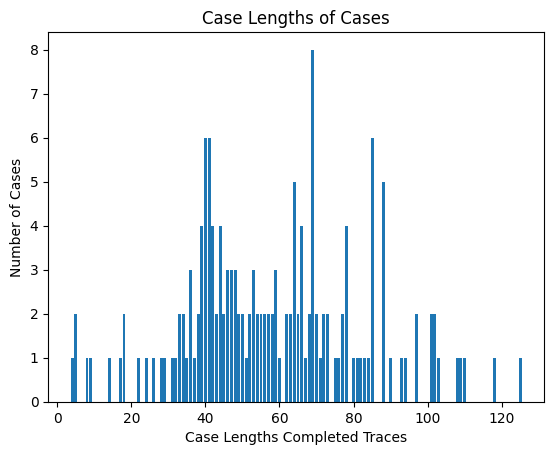

In [14]:
plt.bar(case_lengths.index, case_lengths.values)

# Adding labels and title
plt.xlabel('Case Lengths Completed Traces')
plt.ylabel('Number of Cases')
plt.title('Case Lengths of Cases')

plt.show()

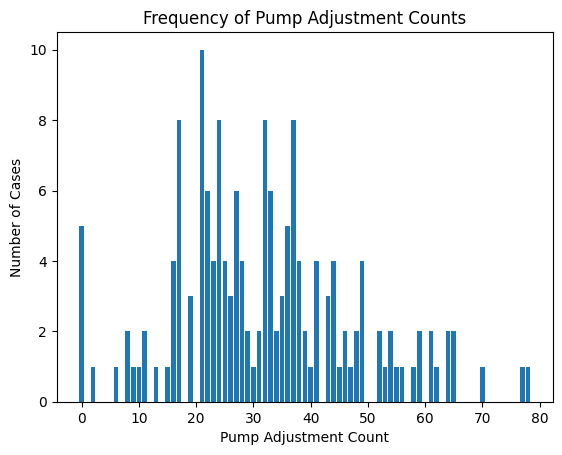

In [15]:
# Create a bar plot
plt.bar(case_frequency_counts.index, case_frequency_counts.values)

# Adding labels and title
plt.xlabel('Pump Adjustment Count')
plt.ylabel('Number of Cases')
plt.title('Frequency of Pump Adjustment Counts')

plt.show()

As you can see in the first plot, there are a lot of cases of different lengths.

Another thing we notice in the second plot is that some cases have up to almost 80 pump adjustments. There are also some cases that have no pump adjustment at all. 

In [ ]:
# calculate the case lengths
case_lengths_id = dt_train_prefixes.groupby('prefix_nr')['CaseID'].nunique()
# Create a bar plot
plt.bar(case_lengths_id.index, case_lengths_id.values)

# Adding labels and title
plt.xlabel('Case Length')
plt.ylabel('Number of Cases')
plt.title('Case Lengths of Cases')

plt.show()

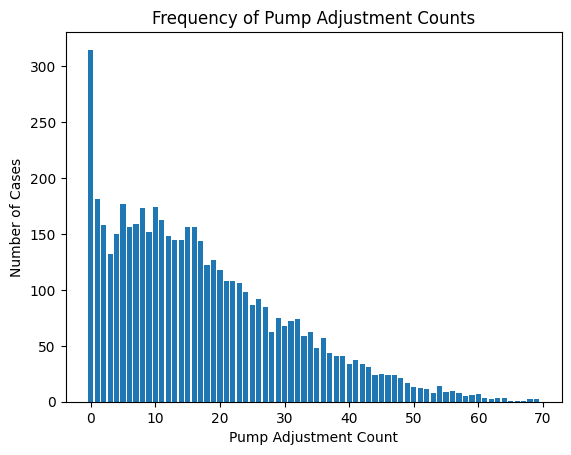

In [8]:
# Calculate the frequency of 'Pump_Adjustment_Count' values across cases
case_frequency_counts = dt_train_prefixes.groupby('Remaining_Adjustment')['CaseID'].nunique()

# Create a bar plot
plt.bar(case_frequency_counts.index, case_frequency_counts.values)

# Adding labels and title
plt.xlabel('Pump Adjustment Count')
plt.ylabel('Number of Cases')
plt.title('Frequency of Pump Adjustment Counts')

plt.show()

In [9]:
# Calculate the frequency of 'Pump_Adjustment_Count' values across cases
print(dt_train_prefixes.groupby('Remaining_Adjustment')['CaseID'].nunique().index.max())
print(dt_test_prefixes.groupby('Remaining_Adjustment')['CaseID'].nunique().index.max())

69.0
78.0


In [10]:
# Calculate the frequency of 'Pump_Adjustment_Count' values across cases
print(dt_train_prefixes.groupby('Remaining_Adjustment')['CaseID'].nunique().index.min())
print(dt_test_prefixes.groupby('Remaining_Adjustment')['CaseID'].nunique().index.min())

0.0
0.0


These are the frequency of the prefixes after taking all the prefixes. 